In [93]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import copy

Параметры (даны по условию)

In [94]:
alpha = 0.6     # Параметр альфа
delta_t = 0.5   # Период дискретизации
sigma = 0.5     # стандартное отклонение для шума w_n
delta = 1.5     # стандартное отклонение для шума v_n^l (дБ)
beta = 3        # коэффициент среды распространения сигнала
L = 6           # Число станций
P0 = 90         # Мощность сигнала, передаваемого базовой станцией (дБ)
M = 10          # Число частиц


x = np.random.multivariate_normal(np.zeros((L)), np.diag((500, 5, 5, 200, 5, 5)), M)  # Начальное состояние системы
u = np.random.randint(0, 4, M)             # Индекс начального состояния марковской цепи для каждой частицы
ans = []

Матрицы A, B, C с тильдой (даны по условию)

In [95]:
# Матрицы A, B, C с тильдой
A_tilde = np.array([
    [1, delta_t, delta_t**2 / 2],
    [0, 1, delta_t],
    [0, 0, alpha]
])

B_tilde = np.array([
    [delta_t**2 / 2],
    [delta_t],
    [0]
])

C_tilde = np.array([
    [delta_t**2 / 2],
    [delta_t],
    [1]
])

Матрицы A, B, C (даны по условию)

In [96]:
zeros_3x3 = np.zeros((3, 3))
zeros_3x1 = np.zeros((3, 1))

# Матрицы A, B, C
A = np.block([
    [A_tilde, zeros_3x3],
    [zeros_3x3, A_tilde]
])

B = np.block([
    [B_tilde, zeros_3x1],
    [zeros_3x1, B_tilde]
])

C = np.block([
    [C_tilde, zeros_3x1],
    [zeros_3x1, C_tilde]
])

Остальные матрицы (даны по условию)

In [97]:
# Управляющие команды u_n
U = np.array([
    [0, 0],
    [3.5, 0],
    [0, 3.5],
    [-3.5, 0],
    [0, -3.5]
])

# Матрица переходных вероятностей P
P = np.array([
    [16, 1, 1, 1, 1],
    [1, 16, 1, 1, 1],
    [1, 1, 16, 1, 1],
    [1, 1, 1, 16, 1],
    [1, 1, 1, 1, 16]
]) / 20

Считывание данных

In [98]:
def read_file(file_name):
    with open(file_name, 'r') as f:
        data_lines = [line.strip().split() for line in f]
    return np.array(data_lines, dtype=float).T

In [99]:
stations = read_file('stations.txt')
y = read_file('RSSI-measurements.txt')

print(stations)     # Станции
print('============================================================')
print(y)            # Показания станций (наблюдения)

[[    0.      4000.    ]
 [    0.     -4000.    ]
 [ 3464.1016  2000.    ]
 [ 3464.1016 -2000.    ]
 [-3464.1016 -2000.    ]
 [-3464.1016  2000.    ]]
[[-18.67918   -18.248671  -17.303319  -17.173036  -18.115797  -17.553736 ]
 [-16.269286  -18.623889  -16.816012  -18.594344  -18.118293  -17.972993 ]
 [-18.83336   -16.180802  -19.280249  -19.279911  -18.00498   -17.405444 ]
 ...
 [ -5.4839427 -27.471672  -12.888184  -21.71415   -27.468836  -22.955865 ]
 [ -7.9050906 -26.371108  -11.930547  -20.16127   -23.442843  -17.902805 ]
 [ -4.209267  -25.189529  -11.057371  -22.052968  -21.621816  -19.883949 ]]


In [100]:
print(y.shape)   # 501 наблюдение. Каждое наблюдение содержит 6 значений (так как 6 станций)

(501, 6)


In [101]:
# Цикл по всем наблюдениям (измерениям) в наборе данных
for i in range(len(y)):
    w = np.zeros((M))
    # Цикл по всем частицам
    for j in range(M):
        # ------------------------ 1. Предсказание ------------------------
        trans = stats.rv_discrete(values=(np.arange(5), P[u[j]]))     # Дискретное распределение для выбора управления 
        u[j] = trans.rvs()                                            # Случайное управление согласно распределению

        # Прогноз нового состояния частицы (по формуле)
        x[j] = np.dot(A, x[j]) + \
               np.dot(B, U[u[j]]) + \
               np.dot(C, np.random.multivariate_normal(np.zeros((2)), np.diag((sigma ** 2, sigma ** 2))))

        # ------------------------ 2. Обновление весов ------------------------
        y_t = np.zeros(L)
        for k in range(L):    # Все станции (L = 6)
            particle_pos = x[j][[0, 3]]    # Координаты положения (индексы 0 и 3)
            station_pos = stations[k]      # Позиция k-й станции
            
            # Расстояние от частицы до k-й станции 
            dist = np.sqrt((particle_pos[0] - station_pos[0])**2 + 
                           (particle_pos[1] - station_pos[1])**2)

            # Модель наблюдения
            y_t[k] = P0 - 10 * beta * np.log10(dist)

        # Вычисление веса частицы после сбора всех измерений
        squared_diff = np.sum((y_t - y[i])**2)          # Сумма квадратов разниц по всем станциям
        w[j] = np.exp(-squared_diff / (2 * delta**2))

    # ------------------------ 3. Оценка текущего состояния ------------------------
    w /= sum(w)  # Нормализация весов

    # Взвешенная оценка состояния системы
    x_wave = np.zeros(L)
    for j in range(M):
        x_wave += w[j] * x[j]
    ans.append(x_wave)    # Текущая оценка сохраняется в ответ

    # ------------------------ 4. Ресэмплинг ------------------------
    x_samples = copy.deepcopy(x)      # Текущие состояние x
    u_samples = copy.deepcopy(u)      # Текущие состояние u
    
    # Дискретное распределение для индексов частиц согласно их весам
    w_indices = [i for i in range(len(w))]
    w_dist = stats.rv_discrete(values=(w_indices, w))
    
    # Беру частицы с вероятностью, пропорциональной их весу
    for j in range(M):
        resample_index = w_dist.rvs()
        x[j] = x_samples[resample_index]
        u[j] = u_samples[resample_index]

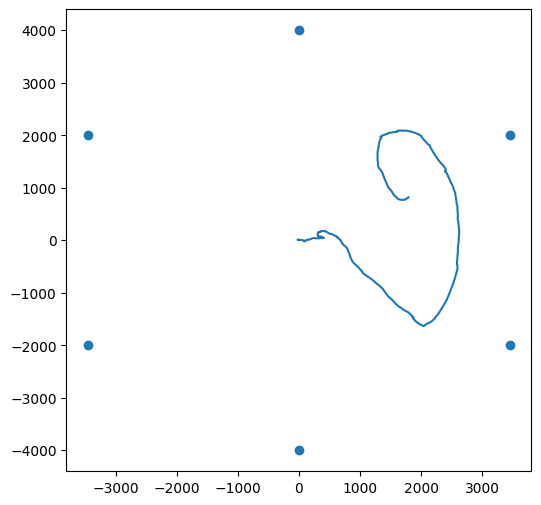

In [102]:
plt.figure(figsize=(6, 6))
plt.scatter(stations[:,0], stations[:, 1])
ans = np.array(ans)
plt.plot(ans[:, 0], ans[:, 3])
plt.show()